In [12]:
from pathlib import Path
import sys
import glob
import json

import numpy as np
import cv2
import open3d as o3d
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 6)

# ------------ EDIT THESE TWO LINES ------------
# Folder where you UNZIPPED `tum-traffic-dataset-dev-kit.zip`
# This folder must directly contain `src/` and `calib/`
REPO_ROOT = Path(r"C:\Users\mcsmu\Desktop\Projec\tum-traffic-dataset-dev-kit")

# Folder where your intersection dataset lives
DATA_ROOT = Path(r"C:\Users\mcsmu\Desktop\intersection")
# ----------------------------------------------

# Add dev-kit to Python path
sys.path.append(str(REPO_ROOT))

from src.utils.perspective import parse_perspective
from src.utils.utils import id_to_class_name_mapping, class_name_to_id_mapping


In [13]:
# Camera folders
IMG_S1_DIR = DATA_ROOT / "images" / "s110_camera_basler_south1_8mm"
IMG_S2_DIR = DATA_ROOT / "images" / "s110_camera_basler_south2_8mm"

# LiDAR folders
LIDAR_N_DIR = DATA_ROOT / "point_clouds" / "s110_lidar_ouster_north"
LIDAR_S_DIR = DATA_ROOT / "point_clouds" / "s110_lidar_ouster_south"

# Label folders (point-cloud OpenLABEL)
LBL_N_DIR = DATA_ROOT / "labels_point_clouds" / "s110_lidar_ouster_north"
LBL_S_DIR = DATA_ROOT / "labels_point_clouds" / "s110_lidar_ouster_south"


def sorted_files(folder, pattern):
    if not folder.exists():
        return []
    return sorted(glob.glob(str(folder / pattern)))


img_s1_files = sorted_files(IMG_S1_DIR, "*.jpg")
img_s2_files = sorted_files(IMG_S2_DIR, "*.jpg")
lidar_n_files = sorted_files(LIDAR_N_DIR, "*.pcd")
lidar_s_files = sorted_files(LIDAR_S_DIR, "*.pcd")
lbl_n_files   = sorted_files(LBL_N_DIR, "*.json")
lbl_s_files   = sorted_files(LBL_S_DIR, "*.json")

print("Images south1:", len(img_s1_files))
print("Images south2:", len(img_s2_files))
print("LiDAR north :", len(lidar_n_files))
print("LiDAR south :", len(lidar_s_files))
print("Labels north:", len(lbl_n_files))
print("Labels south:", len(lbl_s_files))

lengths = [
    len(x) for x in [img_s1_files, img_s2_files,
                     lidar_n_files, lidar_s_files,
                     lbl_n_files, lbl_s_files]
    if len(x) > 0
]
N = min(lengths) if lengths else 0
print("Usable frames (all sensors present):", N)

if N == 0:
    raise ValueError("No matching frames found; check your folders and filenames.")

FRAME_IDX = 0
print("Example frame index:", FRAME_IDX)


Images south1: 2160
Images south2: 2160
LiDAR north : 2160
LiDAR south : 2160
Labels north: 2160
Labels south: 2160
Usable frames (all sensors present): 2160
Example frame index: 0


In [14]:
cam_s1_calib_path = REPO_ROOT / "calib" / "s110_camera_basler_south1_8mm.json"
cam_s2_calib_path = REPO_ROOT / "calib" / "s110_camera_basler_south2_8mm.json"

print("South1 calib:", cam_s1_calib_path)
print("South2 calib:", cam_s2_calib_path)

persp_s1 = parse_perspective(str(cam_s1_calib_path))
persp_s2 = parse_perspective(str(cam_s2_calib_path))

print("S1 has lidar north proj:", persp_s1.projection_from_lidar_north is not None)
print("S1 has lidar south proj:", persp_s1.projection_from_lidar_south is not None)
print("S2 has lidar north proj:", persp_s2.projection_from_lidar_north is not None)
print("S2 has lidar south proj:", persp_s2.projection_from_lidar_south is not None)


South1 calib: C:\Users\mcsmu\Desktop\Projec\tum-traffic-dataset-dev-kit\calib\s110_camera_basler_south1_8mm.json
South2 calib: C:\Users\mcsmu\Desktop\Projec\tum-traffic-dataset-dev-kit\calib\s110_camera_basler_south2_8mm.json
Loading perspective from C:\Users\mcsmu\Desktop\Projec\tum-traffic-dataset-dev-kit\calib\s110_camera_basler_south1_8mm.json...
Loading perspective from C:\Users\mcsmu\Desktop\Projec\tum-traffic-dataset-dev-kit\calib\s110_camera_basler_south2_8mm.json...
S1 has lidar north proj: True
S1 has lidar south proj: True
S2 has lidar north proj: True
S2 has lidar south proj: True


In [15]:
# Per-class colors (BGR for OpenCV)
CLASS_COLORS = {
    "CAR":        (0, 255,   0),
    "BUS":        (0, 255, 255),
    "TRUCK":      (0, 165, 255),
    "VAN":        (255,   0, 255),
    "PEDESTRIAN": (255,   0,   0),
    "CYCLIST":    (255, 128,   0),
    "MOTORCYCLE": (128,   0, 255),
}

def get_class_color(category: str):
    if category is None:
        return (0, 255, 0)
    return CLASS_COLORS.get(category.upper(), (255, 255, 255))


def extract_lidar_boxes(label_data):
    """
    From OpenLABEL point-cloud label JSON, extract:
    [
      {
        'id': obj_id,
        'category': 'CAR' / 'BUS' / 'TRUCK' / ... / 'UNKNOWN',
        'corners': (8,3) np.array in LIDAR coordinates
      }, ...
    ]
    """

    boxes = []

    openlabel = label_data.get("openlabel", label_data)
    frames = openlabel.get("frames", {})
    if not frames:
        print("No 'frames' key in label JSON.")
        return boxes

    frame_key = next(iter(frames.keys()))
    frame = frames[frame_key]
    objects = frame.get("objects", {})

    for obj_id, obj in objects.items():
        od = obj.get("object_data", {})

        # --- category extraction ---
        cat_candidates = []

        if "type" in obj:
            cat_candidates.append(obj["type"])
        if "type" in od:
            cat_candidates.append(od["type"])
        if "subtype" in od:
            cat_candidates.append(od["subtype"])
        if "category" in od:
            cat_candidates.append(od["category"])

        cuboid = od.get("cuboid", {})
        attrs = cuboid.get("attributes", {})
        if "text" in attrs:
            text_attr = attrs["text"]
            if isinstance(text_attr, dict):
                maybe_text = text_attr.get("val")
                if maybe_text:
                    cat_candidates.append(maybe_text)
            elif isinstance(text_attr, list):
                for entry in text_attr:
                    if isinstance(entry, dict):
                        maybe_text = entry.get("val")
                        if maybe_text:
                            cat_candidates.append(maybe_text)

        category_raw = None
        for c in cat_candidates:
            if c is not None and str(c).strip() != "":
                category_raw = c
                break

        category = "UNKNOWN"
        if category_raw is not None:
            if isinstance(category_raw, (int, float)) or str(category_raw).isdigit():
                key = str(int(category_raw))
                if key in id_to_class_name_mapping:
                    category = id_to_class_name_mapping[key].get("class_label_en", f"ID{key}").upper()
                else:
                    category = f"ID{key}"
            else:
                category = str(category_raw).upper()

        if "cuboid" not in od or "val" not in od["cuboid"]:
            continue

        cuboid_val = od["cuboid"]["val"]
        if len(cuboid_val) < 10:
            continue

        cx, cy, cz = cuboid_val[0], cuboid_val[1], cuboid_val[2]
        center = np.array([cx, cy, cz], dtype=float)

        quat = np.array(cuboid_val[3:7], dtype=float)  # [qx, qy, qz, qw]
        l, w, h = cuboid_val[7], cuboid_val[8], cuboid_val[9]

        bb = np.array(
            [
                [-l / 2, -l / 2,  l / 2,  l / 2, -l / 2, -l / 2,  l / 2,  l / 2],
                [ w / 2, -w / 2, -w / 2,  w / 2,  w / 2, -w / 2, -w / 2,  w / 2],
                [-h / 2, -h / 2, -h / 2, -h / 2,  h / 2,  h / 2,  h / 2,  h / 2],
            ]
        )

        rot = R.from_quat(quat).as_matrix()
        corners = (rot @ bb).T + center  # (8,3)

        boxes.append({
            "id": obj_id,
            "category": category,
            "corners": corners,
        })

    print(f"Extracted {len(boxes)} boxes. Categories (first few): {[b['category'] for b in boxes[:10]]}")
    return boxes


In [16]:
def draw_box_on_image_from_corners(img, corners_2d, color=(0, 255, 0), thickness=2):
    c = corners_2d.astype(int)
    edges = [
        (0,1),(1,2),(2,3),(3,0),
        (4,5),(5,6),(6,7),(7,4),
        (0,4),(1,5),(2,6),(3,7),
    ]
    for i,j in edges:
        cv2.line(img, tuple(c[i]), tuple(c[j]), color, thickness)


def draw_label_at_box(img, corners_2d, text, color=(0,255,0)):
    x_min = int(np.min(corners_2d[:,0]))
    y_min = int(np.min(corners_2d[:,1]))
    org = (x_min, max(y_min - 10, 0))

    font_scale = 0.7
    thickness  = 2
    (tw, th), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)

    cv2.rectangle(
        img,
        (org[0], org[1] - th - 2),
        (org[0] + tw + 2, org[1] + 2),
        (0, 0, 0),
        cv2.FILLED
    )
    cv2.putText(
        img,
        text,
        org,
        cv2.FONT_HERSHEY_SIMPLEX,
        font_scale,
        color,
        thickness,
        cv2.LINE_AA
    )


def add_panel_border(img, color=(255,255,255), thickness=2):
    h, w = img.shape[:2]
    cv2.rectangle(img, (0,0), (w-1, h-1), color, thickness)
    return img


def add_frame_id_text(img, frame_idx, text_prefix="Frame"):
    text = f"{text_prefix}: {frame_idx}"
    cv2.putText(
        img,
        text,
        (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.8,
        (255,255,255),
        2,
        cv2.LINE_AA
    )
    return img


In [17]:
def make_bev_color(points_xyz, x_range=(-60, 60), y_range=(-60, 60), res=0.2):
    x_min, x_max = x_range
    y_min, y_max = y_range

    width  = int((x_max - x_min) / res)
    height = int((y_max - y_min) / res)

    bev = np.zeros((height, width, 3), dtype=np.uint8)

    xs = points_xyz[:, 0]
    ys = points_xyz[:, 1]

    mask = (xs >= x_min) & (xs < x_max) & (ys >= y_min) & (ys < y_max)
    xs = xs[mask]
    ys = ys[mask]

    ix = ((xs - x_min) / res).astype(int)
    iy = (height - 1 - ((ys - y_min) / res).astype(int))

    ix = np.clip(ix, 0, width - 1)
    iy = np.clip(iy, 0, height - 1)

    bev[iy, ix] = (150, 150, 150)
    return bev


def overlay_boxes_and_labels_on_bev_color(
    bev_bgr,
    boxes,
    x_range=(-60, 60),
    y_range=(-60, 60),
    res=0.2
):
    x_min, x_max = x_range
    y_min, y_max = y_range

    height, width = bev_bgr.shape[:2]
    bev_out = bev_bgr.copy()

    for b in boxes:
        corners = b["corners"]
        cat = b.get("category", "UNK")
        color = get_class_color(cat)

        bottom = corners[:4, :2]
        xs = bottom[:, 0]
        ys = bottom[:, 1]

        ix = ((xs - x_min) / res).astype(int)
        iy = (height - 1 - ((ys - y_min) / res).astype(int))

        pts = np.stack([ix, iy], axis=1)
        pts[:, 0] = np.clip(pts[:, 0], 0, width - 1)
        pts[:, 1] = np.clip(pts[:, 1], 0, height - 1)

        # thin footprint edges
        for i in range(4):
            x1, y1 = pts[i]
            x2, y2 = pts[(i + 1) % 4]
            cv2.line(bev_out, (x1, y1), (x2, y2), color, 1)

        cx = int(np.mean(pts[:, 0]))
        cy = int(np.mean(pts[:, 1]))
        text = cat

        font_scale = 0.4
        thickness  = 1
        (tw, th), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)

        cv2.rectangle(
            bev_out,
            (cx, cy - th - 2),
            (cx + tw + 2, cy + 2),
            (0, 0, 0),
            cv2.FILLED
        )
        cv2.putText(
            bev_out,
            text,
            (cx, cy),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            color,
            thickness,
            cv2.LINE_AA
        )

    return bev_out


In [18]:
OUTPUT_ROOT = DATA_ROOT / "fusion_outputs"
OUTPUT_ROOT.mkdir(parents=True, exist_ok=True)

FUSION1_FRAMES_DIR = OUTPUT_ROOT / "fusion1_frames"
FUSION2_FRAMES_DIR = OUTPUT_ROOT / "fusion2_frames"
FUSION1_FRAMES_DIR.mkdir(exist_ok=True)
FUSION2_FRAMES_DIR.mkdir(exist_ok=True)

FUSION1_VIDEO_PATH = str(OUTPUT_ROOT / "fusion1_cams_bev.mp4")
FUSION2_VIDEO_PATH = str(OUTPUT_ROOT / "fusion2_bev_triplet.mp4")
FPS = 10

print("Output root:", OUTPUT_ROOT)
print("Fusion1 video:", FUSION1_VIDEO_PATH)
print("Fusion2 video:", FUSION2_VIDEO_PATH)


Output root: C:\Users\mcsmu\Desktop\intersection\fusion_outputs
Fusion1 video: C:\Users\mcsmu\Desktop\intersection\fusion_outputs\fusion1_cams_bev.mp4
Fusion2 video: C:\Users\mcsmu\Desktop\intersection\fusion_outputs\fusion2_bev_triplet.mp4


In [25]:
def render_fusion1_frame(frame_idx: int):
    """
    Fusion 1:
      Top-left  : Camera South2
      Top-right : Camera South1
      Bottom    : FUSED BEV (rotated 90° left), full width, no empty panel
    """

    img_s1_path = img_s1_files[frame_idx]
    img_s2_path = img_s2_files[frame_idx]
    lidar_n_path = lidar_n_files[frame_idx]
    lidar_s_path = lidar_s_files[frame_idx]
    lbl_n_path   = lbl_n_files[frame_idx]
    lbl_s_path   = lbl_s_files[frame_idx]

    # images
    img_s1_bgr = cv2.imread(img_s1_path, cv2.IMREAD_COLOR)
    img_s2_bgr = cv2.imread(img_s2_path, cv2.IMREAD_COLOR)

    if img_s1_bgr is None or img_s2_bgr is None:
        raise FileNotFoundError("Could not read one of the camera images.")

    # ensure same size
    Hc, Wc = img_s1_bgr.shape[:2]
    img_s2_bgr = cv2.resize(img_s2_bgr, (Wc, Hc))

    # LiDAR + labels
    pcd_n = o3d.io.read_point_cloud(lidar_n_path)
    pts_n = np.asarray(pcd_n.points)

    pcd_s = o3d.io.read_point_cloud(lidar_s_path)
    pts_s = np.asarray(pcd_s.points)

    with open(lbl_n_path, "r") as f:
        lbl_n_data = json.load(f)
    with open(lbl_s_path, "r") as f:
        lbl_s_data = json.load(f)

    boxes_n = extract_lidar_boxes(lbl_n_data)
    boxes_s = extract_lidar_boxes(lbl_s_data)

    # ---------- South1 fused (top-right) ----------
    img_s1_fused = img_s1_bgr.copy()

    ln = pts_n.T
    ip_n = persp_s1.project_from_lidar_north_to_image(ln)
    u_n, v_n = ip_n[0,:], ip_n[1,:]
    mask_n = (u_n >= 0) & (u_n < Wc) & (v_n >= 0) & (v_n < Hc)
    u_n = u_n[mask_n].astype(int)
    v_n = v_n[mask_n].astype(int)

    ls = pts_s.T
    ip_s = persp_s1.project_from_lidar_south_to_image(ls)
    u_s, v_s = ip_s[0,:], ip_s[1,:]
    mask_s = (u_s >= 0) & (u_s < Wc) & (v_s >= 0) & (v_s < Hc)
    u_s = u_s[mask_s].astype(int)
    v_s = v_s[mask_s].astype(int)

    # yellow points
    for ui, vi in zip(u_n, v_n):
        cv2.circle(img_s1_fused, (ui, vi), 1, (0, 255, 255), -1)
    for ui, vi in zip(u_s, v_s):
        cv2.circle(img_s1_fused, (ui, vi), 1, (0, 255, 255), -1)

    # boxes north
    for b in boxes_n:
        corners = b["corners"]
        proj = persp_s1.project_from_lidar_north_to_image(corners.T)
        corners_2d = np.stack([proj[0,:], proj[1,:]], axis=1)
        inside = (
            (corners_2d[:,0] >= 0) & (corners_2d[:,0] < Wc) &
            (corners_2d[:,1] >= 0) & (corners_2d[:,1] < Hc)
        )
        if not np.any(inside):
            continue
        cat = b["category"]
        color = get_class_color(cat)
        draw_box_on_image_from_corners(img_s1_fused, corners_2d, color=color, thickness=2)
        draw_label_at_box(img_s1_fused, corners_2d, f"N:{cat}", color=color)

    # boxes south
    for b in boxes_s:
        corners = b["corners"]
        proj = persp_s1.project_from_lidar_south_to_image(corners.T)
        corners_2d = np.stack([proj[0,:], proj[1,:]], axis=1)
        inside = (
            (corners_2d[:,0] >= 0) & (corners_2d[:,0] < Wc) &
            (corners_2d[:,1] >= 0) & (corners_2d[:,1] < Hc)
        )
        if not np.any(inside):
            continue
        cat = b["category"]
        color = get_class_color(cat)
        draw_box_on_image_from_corners(img_s1_fused, corners_2d, color=color, thickness=2)
        draw_label_at_box(img_s1_fused, corners_2d, f"S:{cat}", color=color)

    add_panel_border(img_s1_fused)
    cv2.putText(img_s1_fused, "Camera South1", (10, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2, cv2.LINE_AA)

    # ---------- South2 fused (top-left) ----------
    img_s2_fused = img_s2_bgr.copy()

    ln = pts_n.T
    ip_n2 = persp_s2.project_from_lidar_north_to_image(ln)
    u_n2, v_n2 = ip_n2[0,:], ip_n2[1,:]
    mask_n2 = (u_n2 >= 0) & (u_n2 < Wc) & (v_n2 >= 0) & (v_n2 < Hc)
    u_n2 = u_n2[mask_n2].astype(int)
    v_n2 = v_n2[mask_n2].astype(int)

    ls = pts_s.T
    ip_s2 = persp_s2.project_from_lidar_south_to_image(ls)
    u_s2, v_s2 = ip_s2[0,:], ip_s2[1,:]
    mask_s2 = (u_s2 >= 0) & (u_s2 < Wc) & (v_s2 >= 0) & (v_s2 < Hc)
    u_s2 = u_s2[mask_s2].astype(int)
    v_s2 = v_s2[mask_s2].astype(int)

    for ui, vi in zip(u_n2, v_n2):
        cv2.circle(img_s2_fused, (ui, vi), 1, (0, 255, 255), -1)
    for ui, vi in zip(u_s2, v_s2):
        cv2.circle(img_s2_fused, (ui, vi), 1, (0, 255, 255), -1)

    for b in boxes_n:
        corners = b["corners"]
        proj = persp_s2.project_from_lidar_north_to_image(corners.T)
        corners_2d = np.stack([proj[0,:], proj[1,:]], axis=1)
        inside = (
            (corners_2d[:,0] >= 0) & (corners_2d[:,0] < Wc) &
            (corners_2d[:,1] >= 0) & (corners_2d[:,1] < Hc)
        )
        if not np.any(inside):
            continue
        cat = b["category"]
        color = get_class_color(cat)
        draw_box_on_image_from_corners(img_s2_fused, corners_2d, color=color, thickness=2)
        draw_label_at_box(img_s2_fused, corners_2d, f"N:{cat}", color=color)

    for b in boxes_s:
        corners = b["corners"]
        proj = persp_s2.project_from_lidar_south_to_image(corners.T)
        corners_2d = np.stack([proj[0,:], proj[1,:]], axis=1)
        inside = (
            (corners_2d[:,0] >= 0) & (corners_2d[:,0] < Wc) &
            (corners_2d[:,1] >= 0) & (corners_2d[:,1] < Hc)
        )
        if not np.any(inside):
            continue
        cat = b["category"]
        color = get_class_color(cat)
        draw_box_on_image_from_corners(img_s2_fused, corners_2d, color=color, thickness=2)
        draw_label_at_box(img_s2_fused, corners_2d, f"S:{cat}", color=color)

    add_panel_border(img_s2_fused)
    cv2.putText(img_s2_fused, "Camera South2", (10, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2, cv2.LINE_AA)

    # ---------- Top row: S2 | S1 ----------
    top_row = np.hstack([img_s2_fused, img_s1_fused])   # shape: Hc x (2Wc)

    # ---------- Fused BEV (bottom, rotated & full width) ----------
    pts_fused = np.vstack([pts_n, pts_s])
    boxes_all = boxes_n + boxes_s

    bev_fused = make_bev_color(pts_fused, x_range=(-60,60), y_range=(-60,60), res=0.2)
    bev_fused = overlay_boxes_and_labels_on_bev_color(
        bev_fused,
        boxes_all,
        x_range=(-60,60),
        y_range=(-60,60),
        res=0.2
    )
    add_panel_border(bev_fused)
    cv2.putText(bev_fused, "FUSED LiDAR N+S BEV", (10, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2, cv2.LINE_AA)

    # rotate 90° CCW, then resize to match top_row width and same height Hc
    bev_rot = cv2.rotate(bev_fused, cv2.ROTATE_90_COUNTERCLOCKWISE)
    bottom_row = cv2.resize(bev_rot, (top_row.shape[1], Hc), interpolation=cv2.INTER_LINEAR)

    # ---------- Stack vertically: [top_row; bottom_row] ----------
    frame_bgr = np.vstack([top_row, bottom_row])
    add_frame_id_text(frame_bgr, frame_idx, text_prefix="Frame")
    return frame_bgr


In [26]:
def show_fusion1_frame(idx):
    if idx < 0 or idx >= N:
        raise ValueError(f"Index out of range! 0 <= idx < {N}")
    frame = render_fusion1_frame(idx)
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Fusion 1 — Frame {idx}")
    plt.show()

# Example:
# show_fusion1_frame(0)
# show_fusion1_frame(700)


Extracted 9 boxes. Categories (first few): ['CAR', 'BUS', 'CAR', 'VAN', 'CAR', 'CAR', 'BICYCLE', 'CAR', 'CAR']
Extracted 23 boxes. Categories (first few): ['VAN', 'VAN', 'CAR', 'BICYCLE', 'CAR', 'CAR', 'CAR', 'CAR', 'VAN', 'CAR']


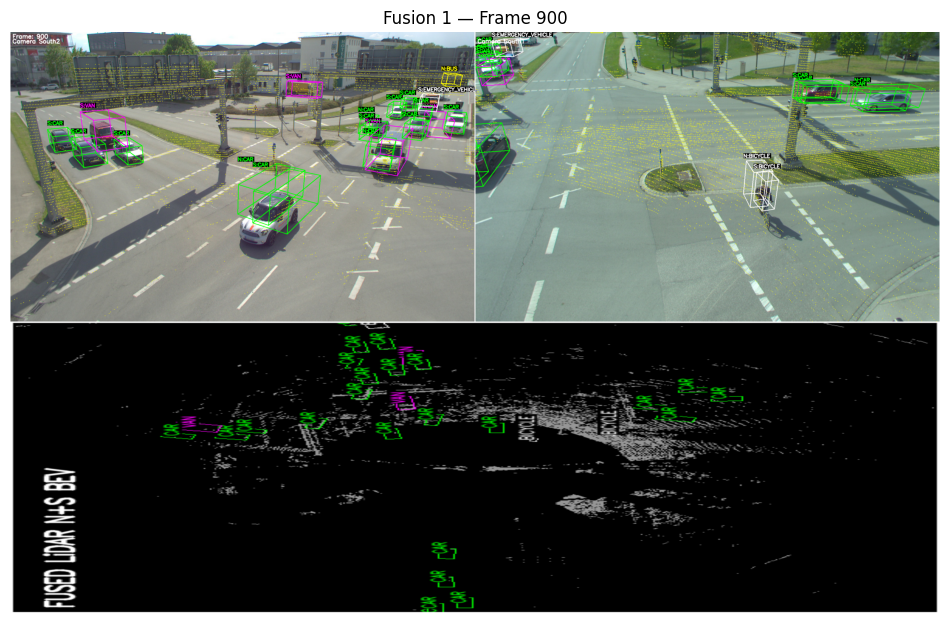

In [28]:
show_fusion1_frame(900)

In [29]:
fourcc = cv2.VideoWriter_fourcc(*"mp4v")

sample = render_fusion1_frame(0)
vh, vw = sample.shape[:2]
video_f1 = cv2.VideoWriter(FUSION1_VIDEO_PATH, fourcc, FPS, (vw, vh))

for idx in range(N):
    frame = render_fusion1_frame(idx)
    if frame.shape[0] != vh or frame.shape[1] != vw:
        frame = cv2.resize(frame, (vw, vh))
    frame_path = FUSION1_FRAMES_DIR / f"fusion1_{idx:05d}.jpg"
    cv2.imwrite(str(frame_path), frame)
    video_f1.write(frame)

video_f1.release()
print("Fusion 1 video saved to:", FUSION1_VIDEO_PATH)


Extracted 9 boxes. Categories (first few): ['VAN', 'PEDESTRIAN', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR']
Extracted 15 boxes. Categories (first few): ['CAR', 'PEDESTRIAN', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR']
Extracted 9 boxes. Categories (first few): ['VAN', 'PEDESTRIAN', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR']
Extracted 15 boxes. Categories (first few): ['CAR', 'PEDESTRIAN', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR']
Extracted 9 boxes. Categories (first few): ['VAN', 'PEDESTRIAN', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR']
Extracted 16 boxes. Categories (first few): ['CAR', 'PEDESTRIAN', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR']
Extracted 10 boxes. Categories (first few): ['VAN', 'PEDESTRIAN', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'TRAILER']
Extracted 18 boxes. Categories (first few): ['CAR', 'PEDESTRIAN', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR']
Extracted 10 boxes. Categories (first few): 

In [30]:
def render_fusion2_frame(frame_idx: int):
    """
    Fusion 2:
      [   BEV North   |    BEV South   ]
      [   (0.8x tall) fused BEV N+S    ]
    """

    lidar_n_path = lidar_n_files[frame_idx]
    lidar_s_path = lidar_s_files[frame_idx]
    lbl_n_path   = lbl_n_files[frame_idx]
    lbl_s_path   = lbl_s_files[frame_idx]

    pcd_n = o3d.io.read_point_cloud(lidar_n_path)
    pts_n = np.asarray(pcd_n.points)

    pcd_s = o3d.io.read_point_cloud(lidar_s_path)
    pts_s = np.asarray(pcd_s.points)

    with open(lbl_n_path, "r") as f:
        lbl_n_data = json.load(f)
    with open(lbl_s_path, "r") as f:
        lbl_s_data = json.load(f)

    boxes_n = extract_lidar_boxes(lbl_n_data)
    boxes_s = extract_lidar_boxes(lbl_s_data)

    # BEV North
    bev_n = make_bev_color(pts_n, x_range=(-60, 60), y_range=(-60, 60), res=0.2)
    bev_n = overlay_boxes_and_labels_on_bev_color(
        bev_n,
        boxes_n,
        x_range=(-60, 60),
        y_range=(-60, 60),
        res=0.2
    )
    add_panel_border(bev_n)
    cv2.putText(bev_n, "LiDAR NORTH BEV", (10, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2, cv2.LINE_AA)

    # BEV South
    bev_s = make_bev_color(pts_s, x_range=(-60, 60), y_range=(-60, 60), res=0.2)
    bev_s = overlay_boxes_and_labels_on_bev_color(
        bev_s,
        boxes_s,
        x_range=(-60, 60),
        y_range=(-60, 60),
        res=0.2
    )
    add_panel_border(bev_s)
    cv2.putText(bev_s, "LiDAR SOUTH BEV", (10, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2, cv2.LINE_AA)

    # same size for N & S
    Hn, Wn = bev_n.shape[:2]
    Hs, Ws = bev_s.shape[:2]
    if (Hn, Wn) != (Hs, Ws):
        bev_s = cv2.resize(bev_s, (Wn, Hn))

    top_row = np.hstack([bev_n, bev_s])
    top_h, top_w = top_row.shape[:2]

    # Fused BEV
    pts_fused = np.vstack([pts_n, pts_s])
    boxes_all = boxes_n + boxes_s

    bev_fused = make_bev_color(pts_fused, x_range=(-60, 60), y_range=(-60, 60), res=0.2)
    bev_fused = overlay_boxes_and_labels_on_bev_color(
        bev_fused,
        boxes_all,
        x_range=(-60, 60),
        y_range=(-60, 60),
        res=0.2
    )
    add_panel_border(bev_fused)
    cv2.putText(bev_fused, "FUSED LiDAR N+S BEV", (10, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2, cv2.LINE_AA)

    bev_target_h = int(top_h * 0.8)
    bev_big = cv2.resize(bev_fused, (top_w, bev_target_h), interpolation=cv2.INTER_LINEAR)

    frame_bgr = np.vstack([top_row, bev_big])
    add_frame_id_text(frame_bgr, frame_idx, text_prefix="Frame")

    return frame_bgr

In [31]:
def show_fusion2_frame(idx):
    """
    Displays Fusion 2 frame:
      [ BEV North | BEV South ]
      [  Fused BEV N+S        ]
    """
    if idx < 0 or idx >= N:
        raise ValueError(f"Index out of range! Choose 0 ≤ idx < {N}")

    frame = render_fusion2_frame(idx)
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Fusion 2 — Frame {idx}")
    plt.show()

# Example usage:
# show_fusion2_frame(0)
# show_fusion2_frame(50)

Extracted 10 boxes. Categories (first few): ['CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'TRAILER', 'CAR', 'PEDESTRIAN', 'VAN']
Extracted 16 boxes. Categories (first few): ['CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'PEDESTRIAN']


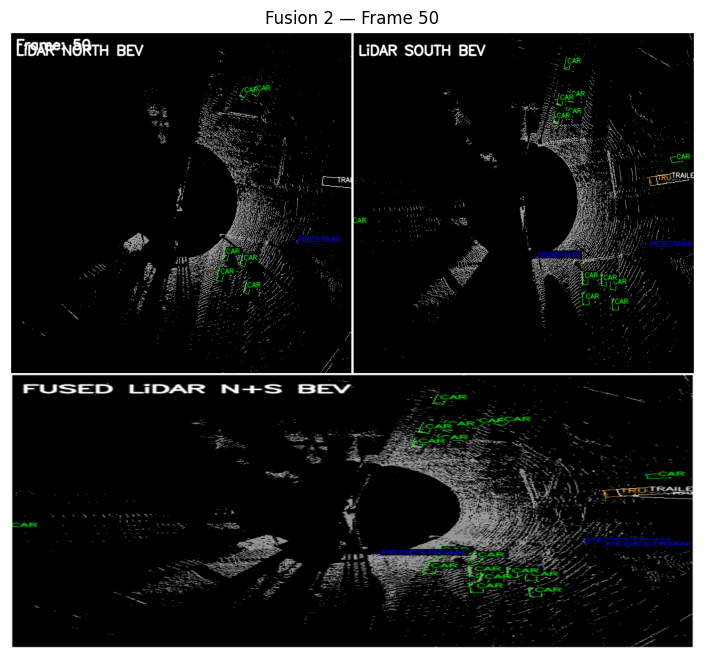

In [32]:
show_fusion2_frame(50)

In [33]:
fourcc2 = cv2.VideoWriter_fourcc(*"mp4v")

sample2 = render_fusion2_frame(0)
vh2, vw2 = sample2.shape[:2]
video_f2 = cv2.VideoWriter(FUSION2_VIDEO_PATH, fourcc2, FPS, (vw2, vh2))

for idx in range(N):
    frame = render_fusion2_frame(idx)
    if frame.shape[0] != vh2 or frame.shape[1] != vw2:
        frame = cv2.resize(frame, (vw2, vh2))
    frame_path = FUSION2_FRAMES_DIR / f"fusion2_{idx:05d}.jpg"
    cv2.imwrite(str(frame_path), frame)
    video_f2.write(frame)

video_f2.release()
print("Fusion 2 video saved to:", FUSION2_VIDEO_PATH)

Extracted 9 boxes. Categories (first few): ['VAN', 'PEDESTRIAN', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR']
Extracted 15 boxes. Categories (first few): ['CAR', 'PEDESTRIAN', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR']
Extracted 9 boxes. Categories (first few): ['VAN', 'PEDESTRIAN', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR']
Extracted 15 boxes. Categories (first few): ['CAR', 'PEDESTRIAN', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR']
Extracted 9 boxes. Categories (first few): ['VAN', 'PEDESTRIAN', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR']
Extracted 16 boxes. Categories (first few): ['CAR', 'PEDESTRIAN', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR']
Extracted 10 boxes. Categories (first few): ['VAN', 'PEDESTRIAN', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'TRAILER']
Extracted 18 boxes. Categories (first few): ['CAR', 'PEDESTRIAN', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR', 'CAR']
Extracted 10 boxes. Categories (first few): 